# Emotion Detection Using Deep Belief Networks

* Import the modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

* Declare the class RBM. The __init__ function will build the complete graph, forward and backward pass, and the objective function. 
* We use the TensorFlow built-in optimizer to update the weights and biases
* Stacked RBMs will be only forward passing the data up to the last MLP layer of DBN. This is achieved by using the rbm_output() function instead of reconstruct() function:

In [2]:

class RBM(object):
    def __init__(self, visible, hidden):
        """
        visible: Number of neurons in visible layer
        hidden: number of neurons in hidden layer
        """
        self._visible = visible
        self._hidden = hidden
                
        
        
        # Create the Computational graph
       
        # Weights and biases
        self._W = tf.Variable(tf.random_normal(shape=(self._visible,self._hidden)))
        self._hidden_bias = tf.Variable(np.zeros(self._hidden).astype(np.float32))  #bias for hidden layer
        self._visible_bias = tf.Variable(np.zeros(self._visible).astype(np.float32))  #bias for Visible layer
            
        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._visible])
                                               
        # Forwards Pass
        _h = tf.nn.sigmoid(tf.matmul(self._X, self._W) + self._hidden_bias)
        self.h = tf.nn.relu(tf.sign(_h - tf.random_uniform(tf.shape(_h))))
                      
            
        #Backward pass
        _v = tf.nn.sigmoid(tf.matmul(self.h, tf.transpose(self._W)) + self._visible_bias)
        self.V = tf.nn.relu(tf.sign(_v - tf.random_uniform(tf.shape(_v))))
                        
                                              
        # Objective Function
        objective = tf.reduce_mean(self.free_energy(self._X)) - tf.reduce_mean(
                              self.free_energy(self.V))
        self._train_op =  tf.train.GradientDescentOptimizer(1e-3).minimize(objective)
        
        # Cross entropy cost
        reconstructed_input = self.one_pass(self._X)
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self._X, logits=reconstructed_input))

            
            
    def set_session(self, session):
        self.session = session
            
                                   
            
    def free_energy(self, V):
        b = tf.reshape(self._visible_bias, (self._visible, 1))
        term_1 = -tf.matmul(V,b)
        term_1 = tf.reshape(term_1, (-1,))
        
        term_2 = -tf.reduce_sum(tf.nn.softplus(tf.matmul(V,self._W) + self._hidden_bias))
        return term_1 + term_2
    
    def one_pass(self, X):
        h = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return tf.matmul(h, tf.transpose(self._W)) + self._visible_bias
    
    def reconstruct(self,X):
        x = tf.nn.sigmoid(self.one_pass(X))
        return self.session.run(x, feed_dict={self._X: X})
     
    def rbm_output(self,X):
        x = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return self.session.run(x, feed_dict={self._X: X})
        
        
    def fit(self, X, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size
        
        obj = []
        for i in range(epochs):
            #X = shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._train_op,self.cost ], feed_dict={self._X: batch})
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format((i+1),ob, j)) 
                obj.append(ob)
        return obj

For the data, consider the Kaggle Face Emotion Recognition data, available at https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge.

# data description

The data consists of 48 x 48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string are space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.
The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

The complete data is in one .csv file called fer2013.csv. We separate out training, validation, and test data from this

In [3]:
data = pd.read_csv('data/fer2013.csv')
tr_data = data[data.Usage == "Training"]
test_data = data[data.Usage == "PublicTest"]
mask = np.random.rand(len(tr_data)) < 0.8
train_data = tr_data[mask]
val_data = tr_data[~mask]

Need to preprocess the data,  
* separate the pixels 
* emotion labels                                                                                                               
dense_to_one_hot () --> it performs the one hot encoding for labels.                                                           
preprocess_data() --> it separates out individual pixels as an array. 

In [4]:
def dense_to_one_hot(labels_dense, num_classes):
     num_labels = labels_dense.shape[0]
     index_offset = np.arange(num_labels) * num_classes
     labels_one_hot = np.zeros((num_labels, num_classes))
     labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
     return labels_one_hot

def preprocess_data(dataframe):
     pixels_values = dataframe.pixels.str.split(" ").tolist()
     pixels_values = pd.DataFrame(pixels_values, dtype=int)
     images = pixels_values.values
     images = images.astype(np.float32)
     images = np.multiply(images, 1.0/255.0)
     labels_flat = dataframe["emotion"].values.ravel()
     labels_count = np.unique(labels_flat).shape[0]
     labels = dense_to_one_hot(labels_flat, labels_count)
     labels = labels.astype(np.uint8)
     return images, labels

The training, validation, and testing data is obtained using the helper functions.

In [5]:
X_train, Y_train = preprocess_data(train_data)
X_val, Y_val = preprocess_data(val_data)
X_test, Y_test = preprocess_data(test_data)

Explore our data a little. We plot the mean image and find the number of images in each training, validation, and testing dataset.

Training Data set has 22984 images
Validation Data set has 5725 images
Test Data set has 3589 images


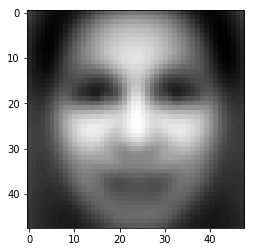

In [6]:
mean_image = X_train.mean(axis=0)
std_image = np.std(X_train, axis=0)
print("Training Data set has {} images".format(len(X_train)))
print("Validation Data set has {} images".format(len(X_val)))
print("Test Data set has {} images".format(len(X_test)))
plt.imshow(mean_image.reshape(48,48), cmap='gray')

Image processing to improve accuracy. Thus we multiply each image by 100.0/255.0

In [7]:
std_image = np.std(X_train, axis=0)
X_train = np.divide(np.subtract(X_train,mean_image), std_image)
X_val = np.divide(np.subtract(X_val,mean_image), std_image)
X_test = np.divide(np.subtract(X_test,mean_image), std_image)

Let's see the images from the training sample and their respective label.

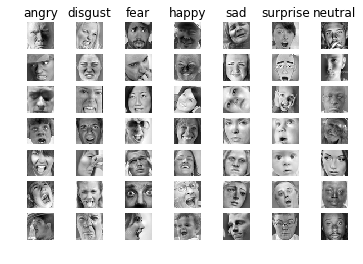

In [8]:
classes = ['angry','disgust','fear','happy','sad','surprise','neutral']
num_classes = len(classes)
samples_per_class = 7
for y,cls in enumerate(classes):
     idxs = np.flatnonzero(np.argmax(Y_train, axis =1) == y)
     idxs = np.random.choice(idxs, samples_per_class, replace=False)
     for i, idx in enumerate(idxs):
         plt_idx = i * num_classes + y + 1
         plt.subplot(samples_per_class, num_classes, plt_idx)
         plt.imshow(X_train[idx].reshape(48,48), cmap='gray') #pixel height and width
         plt.axis('off')
         if i == 0:
             plt.title(cls)
plt.show()

Next, we define the RBM stack; each RBM takes the output of the previous RBM as its input.
* This generates three RBMs: the first RBM with 2,304 (48 × 48) input and 1,500 hidden units, the second RBM with 1,500 input and 700 hidden units, and finally the third RBM with 700 input and 400 hidden units

In [9]:
RBM_hidden_sizes = [1500, 700, 400] #create 4 layers of RBM with size 1500, 700, 400 and 100
#Set input as training data
inpX = X_train
#Create list to hold our RBMs
rbm_list = []
#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]
#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
     print ('RBM: ',(i+1),' ',input_size,'->', size)
     rbm_list.append(RBM(input_size, size))
     input_size = size

RBM:  1   2304 -> 1500
RBM:  2   1500 -> 700
RBM:  3   700 -> 400


Let's train each RBM one by one. The technique is also called greedy wise training.
* Number of epochs for training each RBM is 30

In [10]:
# Greedy wise training of RBMs
init = tf.global_variables_initializer()
for rbm in rbm_list:
     print ('New RBM:')
     #Train a new one
     with tf.Session() as sess:
         sess.run(init)
         rbm.set_session(sess)
         err = rbm.fit(inpX, 30)
         inpX_n = rbm.rbm_output(inpX)
         inpX = inpX_n

New RBM:
training epoch 1 batch 0 cost 0.38297319412231445
training epoch 1 batch 100 cost -694.4852905273438
training epoch 1 batch 200 cost -1458.0067138671875
training epoch 2 batch 0 cost -1505.098876953125
training epoch 2 batch 100 cost -2295.609375
training epoch 2 batch 200 cost -3135.316162109375
training epoch 3 batch 0 cost -3018.825927734375
training epoch 3 batch 100 cost -3897.6806640625
training epoch 3 batch 200 cost -4812.93603515625
training epoch 4 batch 0 cost -4532.8544921875
training epoch 4 batch 100 cost -5500.103515625
training epoch 4 batch 200 cost -6490.681640625
training epoch 5 batch 0 cost -6047.02392578125
training epoch 5 batch 100 cost -7102.64599609375
training epoch 5 batch 200 cost -8168.515625
training epoch 6 batch 0 cost -7561.2412109375
training epoch 6 batch 100 cost -8705.296875
training epoch 6 batch 200 cost -9846.4111328125
training epoch 7 batch 0 cost -9075.51953125
training epoch 7 batch 100 cost -10307.9931640625
training epoch 7 batch 

training epoch 25 batch 0 cost 0.00038945049163885415
training epoch 25 batch 100 cost 0.00763245765119791
training epoch 25 batch 200 cost 0.0004469948180485517
training epoch 26 batch 0 cost 0.0003880869480781257
training epoch 26 batch 100 cost 0.0074187517166137695
training epoch 26 batch 200 cost 0.000446499529061839
training epoch 27 batch 0 cost 0.0003843085723929107
training epoch 27 batch 100 cost 0.007231114897876978
training epoch 27 batch 200 cost 0.0004328410723246634
training epoch 28 batch 0 cost 0.00037189852446317673
training epoch 28 batch 100 cost 0.006924320477992296
training epoch 28 batch 200 cost 0.00041734613478183746
training epoch 29 batch 0 cost 0.0003688042052090168
training epoch 29 batch 100 cost 0.0067591299302875996
training epoch 29 batch 200 cost 0.0004189444880466908
training epoch 30 batch 0 cost 0.00035178352845832705
training epoch 30 batch 100 cost 0.0065464540384709835
training epoch 30 batch 200 cost 0.0004084190004505217
New RBM:
training epoch

Define a DBN class. In the class, we build the complete DBN with the three layers of RBM and two additional MLP layers. The weights of RBM layers are loaded from the pre-trained RBMs. We also declare methods to train and predict the DBN; for fine-tuning, the network tries to minimize the mean square loss function.

In [11]:
import math
class DBN(object):
 
     def __init__(self, sizes, X, Y, eta = 0.001, momentum = 0.0, epochs = 10, batch_size = 100):
         #Initialize hyperparameters
         self._sizes = sizes
         print(self._sizes)
         self._sizes.append(1000) # size of the first FC layer
         self._X = X
         self._Y = Y
         self.N = len(X)
         self.w_list = []
         self.c_list = []
         self._learning_rate = eta
         self._momentum = momentum
         self._epochs = epochs
         self._batchsize = batch_size
         input_size = X.shape[1]
 
         #initialization loop
         for size in self._sizes + [Y.shape[1]]:
             #Define upper limit for the uniform distribution range
             max_range = 4 * math.sqrt(6. / (input_size + size))
 
             #Initialize weights through a random uniform distribution
             self.w_list.append(
             np.random.uniform( -max_range, max_range, [input_size,         size]).astype(np.float32))
 
             #Initialize bias as zeroes
             self.c_list.append(np.zeros([size], np.float32))
             input_size = size
 
 
         # Build DBN
         #Create placeholders for input, weights, biases, output
         self._a = [None] * (len(self._sizes) + 2)
         self._w = [None] * (len(self._sizes) + 1)
         self._c = [None] * (len(self._sizes) + 1)
         self._a[0] = tf.placeholder("float", [None, self._X.shape[1]])
         self.y = tf.placeholder("float", [None, self._Y.shape[1]])
 
         #Define variables and activation function
         for i in range(len(self._sizes) + 1):
             self._w[i] = tf.Variable(self.w_list[i])
             self._c[i] = tf.Variable(self.c_list[i])
         for i in range(1, len(self._sizes) + 2):
             self._a[i] = tf.nn.sigmoid(tf.matmul(self._a[i - 1], self._w[i - 1]) + self._c[i - 1])
 
         #Define the cost function
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits= self._a[-1]))
         #cost = tf.reduce_mean(tf.square(self._a[-1] - self.y))
 
         #Define the training operation (Momentum Optimizer minimizing the Cost function)
         self.train_op = tf.train.AdamOptimizer(learning_rate=self._learning_rate).minimize(cost)
 
         #Prediction operation
         self.predict_op = tf.argmax(self._a[-1], 1)
 
     #load data from rbm
     def load_from_rbms(self, dbn_sizes,rbm_list):
         #Check if expected sizes are correct
         assert len(dbn_sizes) == len(self._sizes)
 
         for i in range(len(self._sizes)):
             #Check if for each RBN the expected sizes are correct
             assert dbn_sizes[i] == self._sizes[i]
 
         #If everything is correct, bring over the weights and biases
         for i in range(len(self._sizes)-1):
             self.w_list[i] = rbm_list[i]._W
             self.c_list[i] = rbm_list[i]._hidden_bias
 
 
     def set_session(self, session):
         self.session = session

    #Training method
     def train(self, val_x, val_y):
         #For each epoch
         num_batches = self.N // self._batchsize
 
         batch_size = self._batchsize
         for i in range(self._epochs):
             #For each step
             for j in range(num_batches):
                 batch = self._X[j * batch_size: (j * batch_size + batch_size)]
                 batch_label = self._Y[j * batch_size: (j * batch_size + batch_size)]
 
                 self.session.run(self.train_op, feed_dict={self._a[0]: batch, self.y: batch_label})
 
                 for j in range(len(self._sizes) + 1):
                     #Retrieve weights and biases
                     self.w_list[j] = sess.run(self._w[j])
                     self.c_list[j] = sess.run(self._c[j])
 
             train_acc = np.mean(np.argmax(self._Y, axis=1) == self.session.run(self.predict_op, feed_dict={self._a[0]: self._X, self.y: self._Y}))
 
             val_acc = np.mean(np.argmax(val_y, axis=1) == self.session.run(self.predict_op, feed_dict={self._a[0]: val_x, self.y: val_y}))
             print (" epoch " + str(i+1) + "/" + str(self._epochs) + " Training Accuracy: " +  str(train_acc) + " Validation Accuracy: " + str(val_acc))
 
     def predict(self, X):
         return self.session.run(self.predict_op, feed_dict={self._a[0]: X})

Now, we train instantiate a DBN object and train it. And predict the labels for the test data.

In [12]:
nNet = DBN(RBM_hidden_sizes, X_train, Y_train, epochs = 80)
with tf.Session() as sess:
     #Initialize Variables
     sess.run(tf.global_variables_initializer())
     nNet.set_session(sess)
     nNet.load_from_rbms(RBM_hidden_sizes,rbm_list)
     nNet.train(X_val, Y_val)
     y_pred = nNet.predict(X_test)

[1500, 700, 400]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

 epoch 1/80 Training Accuracy: 0.2597459101983989 Validation Accuracy: 0.2543231441048035
 epoch 2/80 Training Accuracy: 0.1380960668290985 Validation Accuracy: 0.1434061135371179
 epoch 3/80 Training Accuracy: 0.1380960668290985 Validation Accuracy: 0.1434061135371179
 epoch 4/80 Training Accuracy: 0.1380960668290985 Validation Accuracy: 0.1434061135371179
 epoch 5/80 Training Accuracy: 0.1380960668290985 Validation Accuracy: 0.1434061135371179
 epoch 6/80 Training Accuracy: 0.1380960668290985 Validation Accuracy: 0.1434061135371179
 epoch 7/80 Training Accuracy: 0.14009745910198398 Validation Accuracy: 0.1474235807860262
 epoch 8/80 Training Accuracy: 0.1425339366515837 Validation Accuracy: 0.1481222707423581
 epoch 9/80 Training Accuracy: 0.13813957535676993 Validation Accuracy:

The RBMs learn the hidden representations/features of the model using unsupervised learning and then the fully connected layers added along with pre-trained RBMs are finetuned.